<a href="https://colab.research.google.com/github/rahulkp03/Deep-Learning-Projects/blob/main/TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Transfer-Learning 






In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import tensorflow.keras as keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, UpSampling2D, Flatten, BatchNormalization, Dense, Dropout, GlobalAveragePooling2D
from keras.utils import np_utils
from skimage.transform import resize
from tensorflow.keras.applications.resnet50 import decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

169001437/169001437 [==============================] - 3s 0us/step


In [3]:
#Pre-process the data
x_train = preprocess_input(x_train)
x_test = preprocess_input(x_test)

In [4]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [5]:
datagen = ImageDataGenerator(preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=True))
datagen.fit(x_train)

In [7]:
y_train = np_utils.to_categorical(y_train, 100)
y_test = np_utils.to_categorical(y_test, 100)

In [9]:
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

for layer in resnet_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

model = Sequential()
model.add(UpSampling2D())
model.add(UpSampling2D())
model.add(UpSampling2D())
model.add(resnet_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(.25))
model.add(BatchNormalization())
model.add(Dense(100, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
up_sampling2d_9 (UpSampling2 (None, None, None, None)  0         
_________________________________________________________________
up_sampling2d_10 (UpSampling (None, None, None, None)  0         
_________________________________________________________________
up_sampling2d_11 (UpSampling (None, None, None, None)  0         
_________________________________________________________________
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)              

In [10]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [12]:
history = model.fit_generator(datagen.flow(x_train, y_train,
                                  batch_size=64),
                                  steps_per_epoch=x_train.shape[0] // 64,
                                  epochs=15,
                                  validation_data=(x_test, y_test))

<ipython-input-12-7e57394df979>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(x_train, y_train,


Epoch 1/15
781/781 [==============================] - 524s 643ms/step - loss: 2.0203 - accuracy: 0.4836 - val_loss: 1.0123 - val_accuracy: 0.7019
Epoch 2/15
781/781 [==============================] - 500s 640ms/step - loss: 1.1630 - accuracy: 0.6676 - val_loss: 0.8329 - val_accuracy: 0.7499
Epoch 3/15
781/781 [==============================] - 493s 632ms/step - loss: 0.9847 - accuracy: 0.7121 - val_loss: 0.7766 - val_accuracy: 0.7632
Epoch 4/15
781/781 [==============================] - 493s 631ms/step - loss: 0.8723 - accuracy: 0.7395 - val_loss: 0.7532 - val_accuracy: 0.7717
Epoch 5/15
781/781 [==============================] - 500s 640ms/step - loss: 0.8138 - accuracy: 0.7552 - val_loss: 0.7285 - val_accuracy: 0.7848
Epoch 6/15
781/781 [==============================] - 500s 640ms/step - loss: 0.7477 - accuracy: 0.7728 - val_loss: 0.7552 - val_accuracy: 0.7800
Epoch 7/15
781/781 [==============================] - 500s 640ms/step - loss: 0.6997 - accuracy: 0.7872 - val_loss: 0.7043 -

In [15]:
#model.save_weights("New_cifar100.h5")

In [13]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 36s 114ms/step - loss: 0.7190 - accuracy: 0.7996


[0.7190161943435669, 0.7996000051498413]

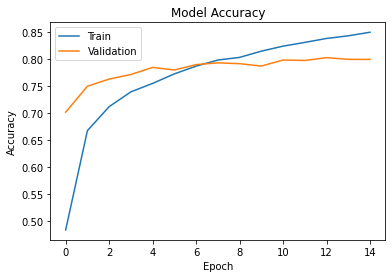

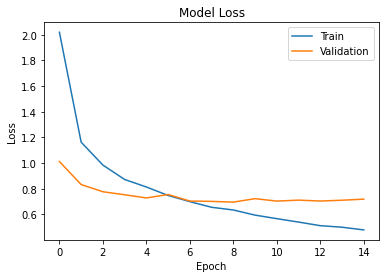

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()